In [3]:
'''
here we'll act like we have a trained weights file, visualize the latent space, make reconstructions, and visualizations of all of those
'''
import numpy as np
import torch
import torch.optim as optim
import my_utils
import models
import utils
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE

In [5]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
%autoreload

In [ ]:
###transfer function



In [34]:
from eztao.carma import DRW_term, DHO_term
from eztao.ts import gpSimRand, gpSimFull
# uniform only really means we don't subsample the other dimensions? 
# firslty it should mean that the sim data we created is uniform  

## 1. make examples, what kinda distribution do we want for the dho/drw parameters? 
## 2. for each example, we would do the convolution for the transfer function
## 3. downsample for whatever cadence we want in each dimension
## 4. make masks
## 5. data loader

def get_synthetic_data(seed = 0, num_samples=100, uniform=False, dims= 2, batch_size=8, sim_params={'SNR':10, 'duration':10*365, 'N':200},  kernel='DRW', drw_kernel_params={'tau':100, 'amp':0.2}, dho_kernel_params = {'a1':1.0, 'a2':1.0, 'b0':1.0,'b1':1.0}):
##### making synthetic data multivariate
    np.random.seed(seed)

    if kernel=='DRW':
        log_amp, log_tau = np.log([drw_kernel_params['amp'], drw_kernel_params['tau']])
        kernel = DRW_term(log_amp, log_tau)

    elif kernel=='DHO':
        log_a1,log_a2,log_b0,log_b1 = np.log([dho_kernel_params['a1'], dho_kernel_params['a2'], dho_kernel_params['b0'], dho_kernel_params['b1']])
        kernel=DHO_term(log_a1,log_a2,log_b0,log_b1)
        
    SNR, duration, N = sim_params['SNR'], sim_params['duration'], sim_params['N']
    # vs gpSimFull for uniform 
    
    #call make masks along each dimension? 
    
    synth = np.array(gpSimRand(kernel, SNR, duration, N, nLC=num_samples)).transpose(1,2,0)[:,np.newaxis]
    synth = np.repeat(synth, dims, axis=1)
    
    # now we would make each band relative to the original by convolution with a computed transfer function
    
    
    # how do the light curves change relative to filter? transfer function from Yu et al. 2022
    
    
    # here we are taking a subset of the original light curve for however many dimensions we want, keeping the original time points so that we can 
    # place values where they need to be for hetvae's input format
    masks = np.zeros((synth.shape[0], synth.shape[1], synth.shape[2], 2))
    print(masks.shape)
    for i in range(synth.shape[1]):
        print(synth[:,i,:,:].shape)
        
        subsampled_mask, recon_mask = my_utils.make_masks(synth[:,i], frac=0.5)
        print(subsampled_mask.shape, recon_mask.shape)
        masks[:,i,:,0] = subsampled_mask
        masks[:,i,:,1] = recon_mask
    samples = np.concatenate((synth, masks), -1)

    samples = samples.astype('float32')
    np.random.shuffle(samples)
    #print(samples.shape)
    splindex = int(np.floor(.8*len(samples)))
    training, valid, test = np.split(samples, [splindex, splindex + int(np.floor(.1*len(samples)))])# shuffle?
    #print(training.shape, valid.shape, test.shape)
    # normalizing?
    
    train_loader = torch.utils.data.DataLoader(training, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)
    max_union_tps = torch.Tensor(max_union_tps)
    
    data_objects = {
        "train_loader": train_loader,
        "test_loader": test_loader,
        "valid_loader": valid_loader,
        'union_tp': max_union_tps,
        "input_dim": dims,
    }
    
    return data_objects

get_synthetic_data()

(100, 2, 200, 2)
(100, 200, 3)
(100, 200) (100, 200)
(100, 200, 3)
(100, 200) (100, 200)
(100, 2, 200, 5)


In [113]:
x = np.arange(10).reshape((1,2,5))
print(x.shape)

np.tile(x, (2,1,1)).shape

(1, 2, 5)


(2, 2, 5)

In [138]:
np.repeat(x,(2,1)).shape

ValueError: operands could not be broadcast together with shape (10,) (2,)

In [134]:
x.shape


(1, 2, 5)

In [2]:
%load_ext autoreload
%autoreload

read 44 files
0 files couldn't be read by pd, 11 were too short, 33 worked
generating 0 new sample of each example in the dataset & appending them 
 old dataset length: 33
new dataset length: 33
created union_x attribute of length 2282
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (33, 719, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
dataset shape (33, 1, 719, 5)
=> loading checkpoint 'synth_5666437.h5'
Namespace(batch_size=8, niters=10, bound_variance=True, const_var=False, dropout=0.0, elbo_weight=4.1, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=True, kl_zero=False, latent_dim=32, lr=0.000586000989264265, mixing='concat', mse_weight=4.0, net='hetvae', norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512, device='mps', data_obj='', checkpoint=''

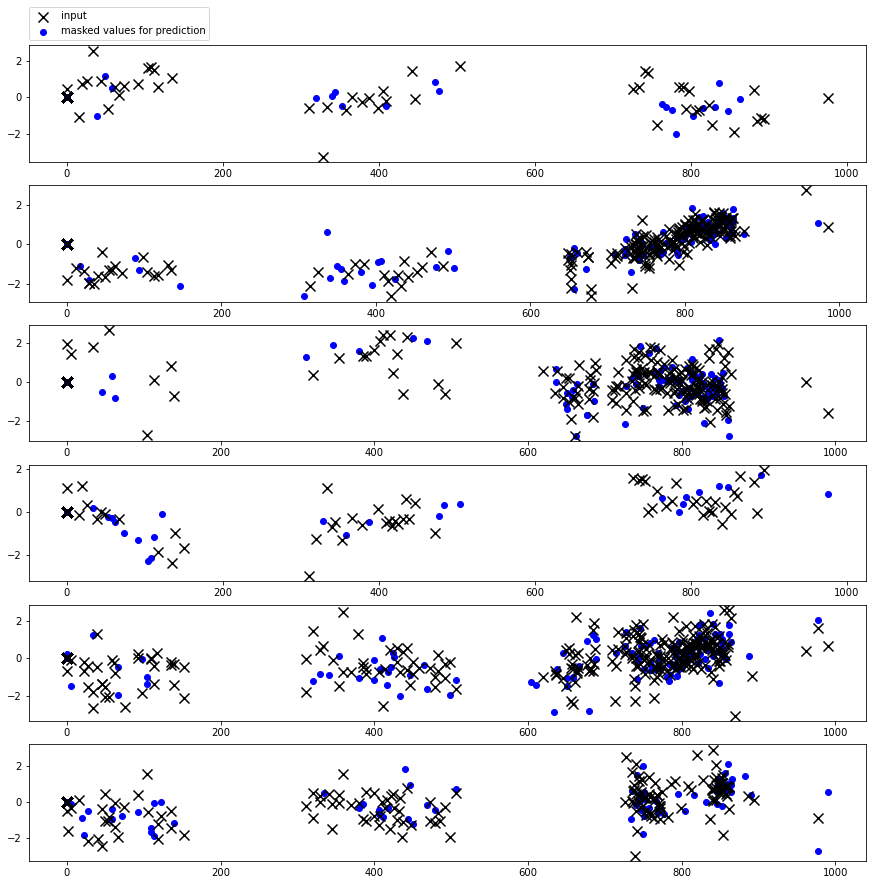

In [88]:
ZTF, data_obj = my_utils.get_data(start_col=1, folder='./rando_data')
ZTF.set_target_x(num_points=400)

net, optimizer, args, epoch, loss =  my_utils.load_checkpoint('synth_5666437.h5', data_obj)

my_utils.plot(data_obj['train_loader'])

=> loading checkpoint 'synth_4217055.h5'
Namespace(batch_size=8, niters=10, bound_variance=True, const_var=False, dropout=0.0, elbo_weight=4.1, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=True, kl_zero=False, latent_dim=32, lr=0.000586000989264265, mixing='concat', mse_weight=4.0, net='hetvae', norm=True, normalize_input='znorm', num_ref_points=32, rec_hidden=32, sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512, device='mps', data_obj='', checkpoint='', early_stopping=False, patience=50, save_at=10, scheduler=True, warmup=4000, data_folder='synth', start_col=0)
1


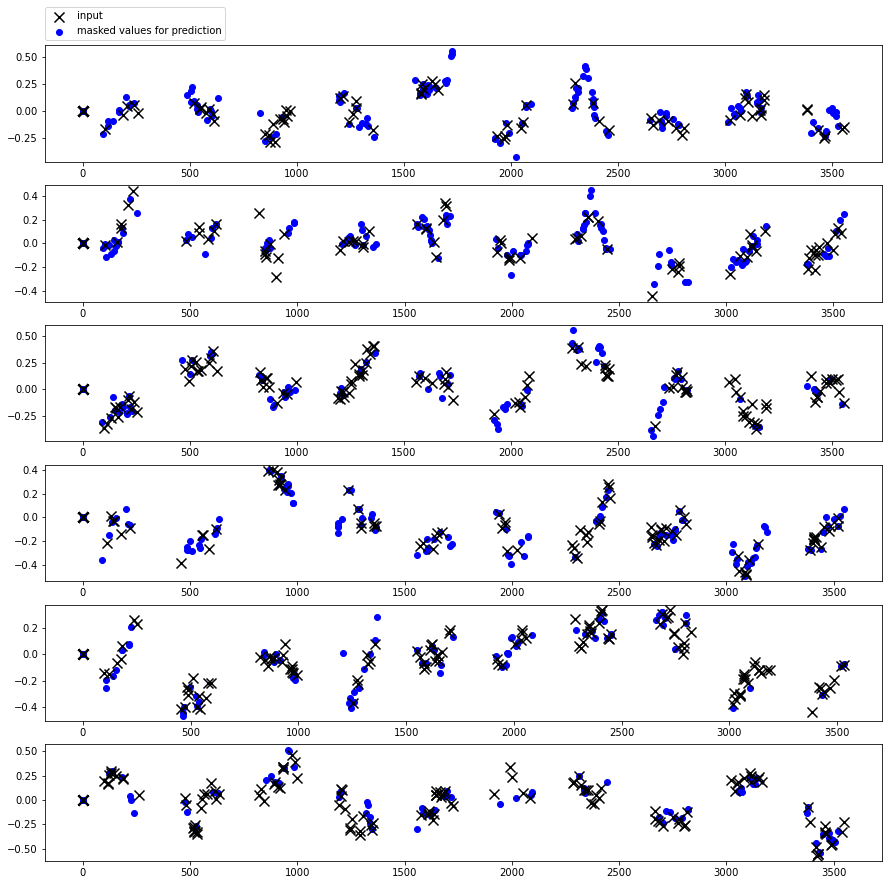

In [71]:
data_obj = my_utils.get_synthetic_data(seed=0, uniform=True)
#{'SNR':10, 'duration':10*365, 'N':200}
# target_x for synthetic data 

net, optimizer, args, epoch, loss =  my_utils.load_checkpoint('synth_4217055.h5', data_obj)

my_utils.plot(data_obj['train_loader'])

(26, 719, 1) (26, 719, 1)
(26, 719, 1) (26, 719, 1)
(26, 719, 1) (26, 719, 1)
(26, 719, 1) (26, 719, 1)
(26, 719, 1) (26, 719, 1)


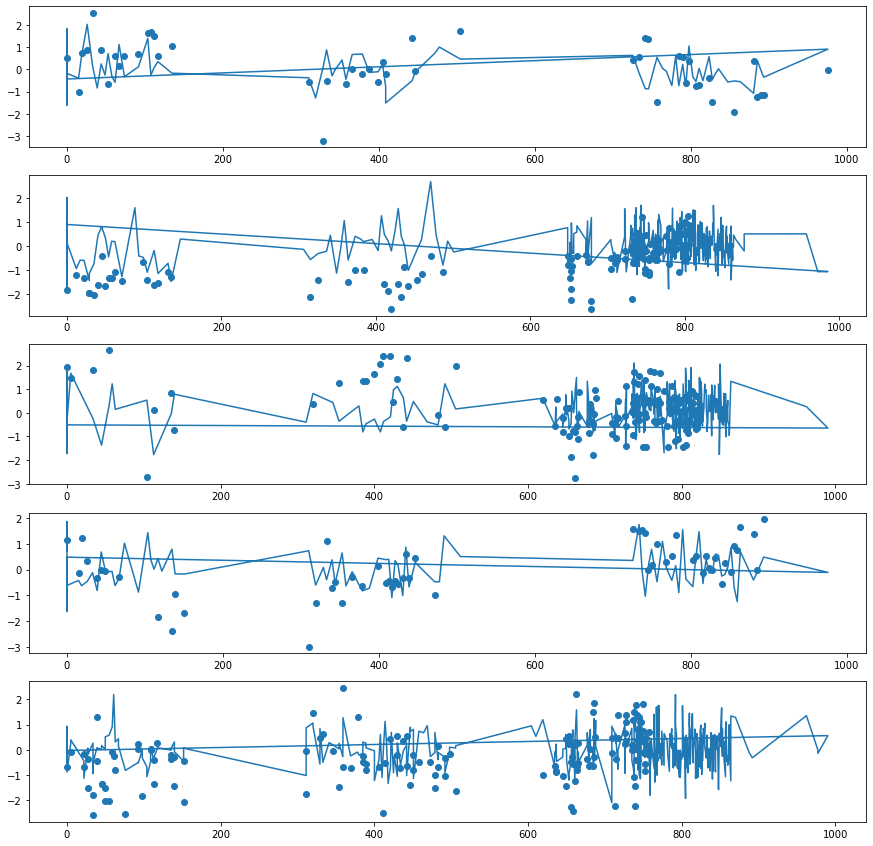

In [90]:
preds, qz_preds, tp, target_tp, inputs = predict(data_obj['train_loader'], subsample=False)
plot_interpolation(preds,tp,target_tp, inputs)

In [86]:
def predict(dataloader, device='mps', k_iwae=2, subsample=False, target_x=None):
    pred_mean, pred_std = [], []
    qz_mean, qz_std = [], []
    masks = []
    targets = []
    tp =[]
    target_tp = []
    np.random.seed(0)
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            
            batch_len = batch.shape[0]

            batch = batch.to(device)
            subsampled_mask = batch[:,:,:,-2]
            recon_mask = batch[:,:,:,-1]
            if subsample == True:
                context_y = torch.cat((batch[:,:,:,1] * subsampled_mask, subsampled_mask), 1).transpose(2,1)
            else:
                context_y = torch.cat((batch[:,:,:,1], batch[:,:,:,1]), 1).transpose(2,1)
            
            if target_x is not None:
                tx = torch.tensor(target_x[i*batch_len:(i*batch_len + batch_len)])
            else:
                tx = batch[:, 0, :,0]

            px, qz = net.get_reconstruction(batch[:, 0, :,0], context_y, tx, num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy())
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
            qz_mean.append(qz.mean.cpu().numpy())
            qz_std.append(torch.exp(0.5 * qz.logvar).cpu().numpy())
            
            targets.append((batch[:, :, :,1]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(batch[:, 0, :,0].cpu().numpy())
            target_tp.append(tx.cpu().numpy())
      
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    qz_mean = np.concatenate(qz_mean, axis=0)
    qz_std = np.concatenate(qz_std, axis=0)
    
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    target_tp = np.concatenate(target_tp, axis=0)
    #print(pred_mean.shape, pred_std.shape, qz_mean.shape, qz_std.shape, targets.shape, masks.shape, tp.shape)
    
    inputs = np.ma.masked_where(masks < 1., targets)
    inputs = np.transpose(inputs, [0,2,1])
    # reparam trick
    preds = np.random.randn(k_iwae//2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    
    qz_preds = np.random.randn(k_iwae//2, k_iwae, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2]) * qz_std + qz_mean
    qz_preds = qz_preds.reshape(-1, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2])
    qz_median = preds.mean(0)
    
    return preds, qz_preds, tp, target_tp, inputs, 

def plot_interpolation(preds, tp, target_tp, inputs, n=5, figsize=(15,15)):
    median = preds.mean(0)
    quantile2 = np.quantile(preds, 0.841, axis=0)
    quantile1 = np.quantile(preds, 0.159, axis=0)
    
    fig,ax = plt.subplots(n,1,figsize=figsize)
    for index in range(n):
        upto = 400 # target_x vs. actual time points # np.argwhere(tp[index] == 0)[0,0]
        print(median.shape, quantile1.shape)
        ax[index].fill_between(target_tp[index, :upto], quantile1[index,0,:upto], quantile2[index,0,:upto], alpha=0.6, facecolor='#65c9f7', interpolate=True)
        #plt.fill_between(tp[index, :upto], median[index,0,:upto] - pred_std[index,0,:upto], median[index,0,:upto] + pred_std[index,0,:upto], alpha=0.6, facecolor='#65c9f7', interpolate=True)
        ax[index].plot(target_tp[index, :upto], median[index, :upto])
        # this stuff is different than the target_x so 
        ax[index].scatter(tp[index, :200], inputs[index, :200])
        
        

In [8]:
# at some point, you wouldn't subsample at all? 



In [9]:
latent = get_latent_dist(data_obj['train_loader'])

(80, 32, 32) (80, 32, 32)
(80, 32, 32)


/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


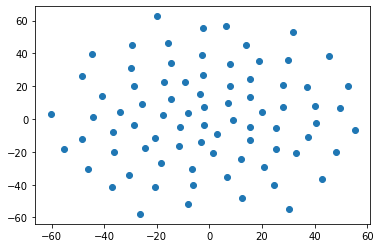

In [10]:
RS = 20150101
latent = latent.reshape((len(latent), -1))
proj = TSNE(random_state=RS).fit_transform(latent)
plt.scatter(proj[:,0], proj[:,1]) # some real clustering going on here

In [ ]:
# visualize attetion ?


In [ ]:
# unnormalize? indexes depend on where we split the train_loader, test_loader, & valid_loader
# we shuffled with the same random seed so the indexes are the same

# also how many points are we predicting? 
def unprocess(preds, dataset):
    pre = dataset.unnormalized_data
    for i, lc in preds:
        std = np.std(pre[i,:,1])
        mean = np.mean(pre[i,:,1])
        t_start = np.min(pre[i,:,0])
        
        lc[:,1] = (lc[:,1] * std) + mean
        lc[:,2] *= std
        lc[:,0] += t_start
    return preds
        
        
     